In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfest import LNP, splineLNP, LNLN, splineLNLN
from rfest import build_design_matrix
from rfest.utils import get_n_samples, split_data, fetch_data, uvec
from rfest.plot import plot_subunits2d, plot_subunits3d, plot2d, plot3d, compare_LNP_and_LNLN

In [2]:
data_rust = fetch_data(1)



(Rust, et al., 2005) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data...
Done.


In [3]:
dt = 0.01
# df = [13, 21]
df = [11, 17]
dims=[16, 24]
num_subunits = 4

n_samples = get_n_samples(20, dt) # 20 mins of the full dataset
stim = data_rust['stim'].T
X = build_design_matrix(stim, dims[0])[:n_samples]
y = data_rust['spikes_per_frm'].flatten()[:n_samples]

(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(X, y, dt, frac_train=0.5, frac_dev=0.1)

SUMMARY
               N    Minutes   Fraction
Total     120000       20.0        1.0
Train      60000       10.0        0.5
Dev        12000        2.0        0.1
Test       48000        8.0        0.4


In [4]:
r1_nospl_lnp = LNP(X_train, y_train, dims=dims, dt=dt, 
                 filter_nonlinearity='softplus', output_nonlinearity='softplus')
r1_nospl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
             num_iters=5000, step_size=0.1,
             beta=.3, verbose=300, random_seed=2046,
             fit_history_filter=False)

r1_spl_lnp = splineLNP(X_train, y_train, dims=dims, dt=dt, df=df,
                 filter_nonlinearity='softplus', output_nonlinearity='softplus')
r1_spl_lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
             num_iters=5000, step_size=0.1,
             beta=.3, verbose=300, random_seed=2046,
             fit_history_filter=False)

r1_nospl_lnln = LNLN(X_train, y_train, dims=dims, dt=dt, 
                 filter_nonlinearity='softplus', output_nonlinearity='softplus')
r1_nospl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
             num_subunits=num_subunits, num_iters=5000, step_size=0.1,
             beta=.5, verbose=300, random_seed=2046,
             fit_history_filter=False)

r1_spl_lnln = splineLNLN(X_train, y_train, dims=dims, dt=dt, df=df,
                 filter_nonlinearity='softplus', output_nonlinearity='softplus')
r1_spl_lnln.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', 
             num_subunits=num_subunits, num_iters=5000, step_size=0.1,
             beta=1., verbose=300, random_seed=2046,
             fit_history_filter=False)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     2.379	 12083.060	  3221.202	     0.073	     0.024
  300	    16.976	-139514.365	-26498.578	     0.111	     0.051
Stop at 301 steps: cost (dev) has been monotonically increasing for 10 steps.

Total time elapsed: 17.024 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     1.091	  8632.750	  1713.743	     0.066	     0.032
  300	    10.668	-139370.491	-26523.095	     0.100	     0.056
Stop at 304 steps: cost (dev) has been monotonically increasing for 10 steps.

Total time elapsed: 10.830 s.
Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     2.003	-19285.192	 -3394.234	     0.080	     0.027
  300	    19.162	-144002.453	-27189.086	     0.373	     0.285
  600	    39.348	-145603.685	-27473.779	     0.416	     0.336
Stop at 633 steps: cost (dev) has been monotonically increasing for 10 steps.

Total time elapsed: 41.568 s.
Iters	  Time (s)	Cost (train)	Cost 

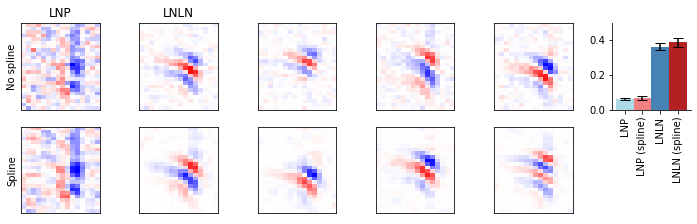

In [10]:
fig, ax = plt.subplots(2, 6, figsize=(12, 3.5))

w = uvec(r1_nospl_lnp.w_opt)
vmax = np.max([np.abs(w.max()), np.abs(w.min())])
ax[0, 0].imshow(uvec(r1_nospl_lnp.w_opt.reshape(dims).T), 
                cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax,
               aspect='auto')


w = uvec(r1_spl_lnp.w_opt.reshape(dims).T)
vmax = np.max([np.abs(w.max()), np.abs(w.min())])
ax[1, 0].imshow(uvec(r1_spl_lnp.w_opt.reshape(dims).T), 
                cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax,
               aspect='auto')

ws0 = uvec(r1_nospl_lnln.w_opt)
vmax0 = np.max([np.abs(ws0.max()), np.abs(ws0.min())])

ws1 = uvec(r1_spl_lnln.w_opt)
vmax1 = np.max([np.abs(ws1.max()), np.abs(ws1.min())])
for i in range(1, 5):
    ax[0, i].imshow(ws0[:, i-1].reshape(dims).T, 
                    cmap=plt.cm.bwr, vmin=-vmax0, vmax=vmax0,
                   aspect='auto')
    ax[1, i].imshow(ws1[:, i-1].reshape(dims).T, 
                    cmap=plt.cm.bwr, vmin=-vmax1, vmax=vmax1,
                   aspect='auto')
    
div = int(X_test.shape[0]/4)
cc_test = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m 
                     in [r1_nospl_lnp, r1_spl_lnp, r1_nospl_lnln, r1_spl_lnln]] for i
                     in range(4)])
cc_test_mean = cc_test.mean(0)
cc_test_std = cc_test.std(0)
x = [0, 1, 2, 3]
ax[0, -1].bar(x, cc_test_mean, yerr=cc_test_std, 
              width=1, 
              color=['lightblue', 'lightcoral', 'steelblue', 'firebrick'], 
              capsize=5)

labels = ['LNP', 'LNP (spline)', 'LNLN', 'LNLN (spline)']



ax = ax.flatten()
for i in range(len(ax)):
    if i == 5: 
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_ylim(0, 0.5)
        
    elif i == 11:
        ax[i].axis('off')
    else:    
        ax[i].set_xticks([])
        ax[i].set_yticks([])

ax[0].set_title('LNP')
ax[0].set_ylabel('No spline')


ax[1].set_title('LNLN')
ax[6].set_ylabel('Spline')

plt.subplots_adjust(wspace=0.5)

# fig.tight_layout()

fig.savefig('fig4b.pdf')